# Crypto Portfolio Analyzer

The purpose of this notebook is to get a better viewpoint into one's crypto portfolio. However, it can also be used for other types of portfolios, especially those with equities. The only restriction is the availablility of historical market data, which most of the time can be found for free from brokers and various websites.

NOTE: Be sure to create and activate a Python 3 virtual environment and install the necessary packages from requirements.txt before continuing.

First, let's import the necessary packages.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now to load some data. First, we load our tradesheet so that we know which cryptos we bought and sold at what time. This information is important as it should be a reflection of how we invested our portfolio. Without an accurate dataset, the following analysis will lose virtually all meaning. Second, let's grab all of the historical market data we'll need to analyze our investments over time.

In [2]:
# Load tradesheet
trades = pd.read_csv('tradesheet.csv', index_col=0)
trades.index = pd.to_datetime(trades.index)

# Determine traded tickers excluding FIAT
fiat = 'usd'
tickers = list(set(trades['Buy']))
tickers = [ticker.lower() for ticker in tickers if ticker.lower() != fiat]

# Assume market data column order
column_names = ['Date', 'Close Price', 'Market Cap', 'Volume']

# Load market data initially retrieved from www.coingecko.com
market_data = {}
for filename in os.listdir('data'):
    ticker = filename.split('-')[0].lower()
    
    # Skip unused tickers
    if ticker not in tickers:
        continue
    
    file_data = pd.read_csv('data' + os.sep + filename)

    # Rename columns
    curr_column_names = list(file_data)
    column_names_map = {curr_column_names[i]: column_names[i] for i in range(len(column_names))}
    file_data.rename(columns=column_names_map, inplace=True)
    
    # Set index to date and convert to np.datetime64
    file_data.set_index(['Date'], inplace=True)
    file_data.index = pd.to_datetime(file_data.index)  
    
    market_data[ticker] = file_data

With our investment activity and historical market data, we can replicate our portfolio as it once occurred in the past. Essentially we're going to performe a simple backtest, with our strategy being equal to our tradesheet. Keep in mind that this doesn't take into account transaction fees and currently only works on daily data.

In [3]:
# Determine the valid trade dates
start_date = min(trades.index.values)
end_date = max([max(data.index.values) for _, data in market_data.items()])
trade_dates = np.arange(start_date, end_date + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))

# Make sure the first trade record is a cash deposit
if not np.isnan(trades.iloc[0]['Sell']):
    raise ValueError('The first row of your tradesheet must be a cash deposit.')

# Intialize holdings and asset performance
holdings = {ticker: 0.0 for ticker in tickers}
holdings[fiat] = trades.iloc[0]['Units']
asset_performance = {trade_date: {ticker: 0.0 for ticker in tickers} for trade_date in trade_dates}

# Remove initial cash deposit from trades
actual_trades = trades.iloc[1:]

# Update holdings based on trade
def update_holdings(trade, holdings):
    # Avoid NaN cells during FIAT deposits and withdrawls
    if not pd.isnull(trade['Sell']):
        holdings[trade['Sell'].lower()] -= trade['Units'] * trade['Value Per Unit']
    if not pd.isnull(trade['Buy']):
        holdings[trade['Buy'].lower()] += trade['Units']
        
# Walk forward each day, execute trading strategy, and record performance
for trade_date in trade_dates:
    # Update holdings based on today's trade(s)
    if trade_date in actual_trades.index:
        todays_trades = actual_trades.loc[trade_date]
        
        if type(todays_trades) is pd.DataFrame:
            # Multiple trades occurred today
            for i in range(len(todays_trades)):
                update_holdings(todays_trades.iloc[i], holdings)
        else:
            # Single trade occurred today
            update_holdings(todays_trades, holdings)
    
    # Mark-to-market portfolio
    for ticker in tickers:
        if trade_date in market_data[ticker].index:
            asset_performance[trade_date][ticker] = \
                holdings[ticker] * market_data[ticker].loc[trade_date]['Close Price']
        else:
            # Fill missing data
            if trade_date > start_date:
                asset_performance[trade_date][ticker] = \
                    asset_performance[trade_date - np.timedelta64(1, 'D')][ticker]

At this point, we have all the data we need to start computing some interesting transformations and statistics.

In [4]:
# Get the portfolio and benchmark performances (doesn't adjust for cash flows)
benchmark_performance = market_data['btc']['Close Price']
benchmark_performance = benchmark_performance[benchmark_performance.index >= start_date]
portfolio_performance = pd.DataFrame(index=trade_dates, columns=['Value'])
for date, assets in asset_performance.items():
    portfolio_performance['Value'].loc[date] = sum([value for ticker, value in assets.items()])

# Compute arithmetic and geometric returns
a_returns = portfolio_performance.pct_change().dropna()
g_returns = np.log(a_returns + 1)
benchmark_a_returns = benchmark_performance.pct_change().dropna()
benchmark_g_returns = np.log(benchmark_a_returns + 1)

# Record cash flows (not including first deposit) and adjust returns and end portfolio value
# NOTE: This is not the most accurate way to adjust for cash flows, but it helps
cash_flows = {}
for trade_date in trade_dates:
    if trade_date in actual_trades.index:
        todays_trades = actual_trades.loc[trade_date]
        
        if type(todays_trades) is pd.DataFrame:
            # Multiple trades occurred today
            for i in range(len(todays_trades)):
                if not pd.isnull(todays_trades['Buy'].iloc[i]) and pd.isnull(todays_trades['Sell'].iloc[i]):
                    cash_flows[trade_date] = -todays_trades['Units'].iloc[i]
                elif pd.isnull(todays_trades['Buy'].iloc[i]) and not pd.isnull(todays_trades['Sell'].iloc[i]):
                    cash_flows[trade_date] = todays_trades['Units'].iloc[i]
        else:
            # Single trade occurred today
            if not pd.isnull(todays_trades['Buy']) and pd.isnull(todays_trades['Sell']):
                cash_flows[trade_date] = -todays_trades['Units']
            elif pd.isnull(todays_trades['Buy']) and not pd.isnull(todays_trades['Sell']):
                cash_flows[trade_date] = todays_trades['Units']

a_returns.drop(cash_flows.keys(), inplace=True)
g_returns.drop(cash_flows.keys(), inplace=True)
neg_g_returns = g_returns[g_returns < 0].dropna()
benchmark_neg_g_returns = benchmark_g_returns[benchmark_g_returns < 0].dropna()
benchmark_g_returns.drop(cash_flows.keys(), inplace=True)
adjusted_end_value = portfolio_performance['Value'].loc[end_date] + np.sum(list(cash_flows.values()))

# Compute benchmark statistics
benchmark_total_return = (benchmark_performance[end_date] / benchmark_performance[start_date]) - 1
benchmark_annualized_return = 365 * benchmark_g_returns.mean()
benchmark_annualized_volatility = np.sqrt(365) * benchmark_g_returns.std()
benchmark_annualized_downside_risk = np.sqrt(365) * benchmark_neg_g_returns.std()
benchmark_sharpe_ratio = benchmark_annualized_return / benchmark_annualized_volatility
benchmark_sortino_ratio = benchmark_annualized_return / benchmark_annualized_downside_risk
benchmark_cagr = ((benchmark_performance[end_date] / benchmark_performance[start_date]) \
                  ** (1 / (len(trade_dates) / 365))) - 1

# Compute portfolio statistics
total_return = (adjusted_end_value / portfolio_performance['Value'].loc[start_date]) - 1
annualized_return = 365 * g_returns.mean()
annualized_volatility = np.sqrt(365) * g_returns.std()
annualized_downside_risk = np.sqrt(365) * neg_g_returns.std()
sharpe_ratio = annualized_return / annualized_volatility
sortino_ratio = annualized_return / annualized_downside_risk
cagr = ((adjusted_end_value / portfolio_performance['Value'].loc[start_date]) \
        ** (1 / (len(trade_dates) / 365))) - 1
covariance_matrix = pd.concat([g_returns['Value'], benchmark_g_returns], axis=1).dropna().cov()
beta = covariance_matrix.iloc[0].iloc[1] / covariance_matrix.iloc[1].iloc[1]
alpha = annualized_return - (beta * 365 * benchmark_g_returns.mean())

# Compute rolling statistics
window = 91  # 3 months
# window = 183  # 6 months
benchmark_rolling_g_returns = benchmark_g_returns.rolling(window)
portfolio_rolling_g_returns = g_returns.rolling(window)
benchmark_rolling_volatility = np.sqrt(365 / window) * benchmark_rolling_g_returns.std().dropna()
portfolio_rolling_volatility = np.sqrt(365 / window) * portfolio_rolling_g_returns.std().dropna()

# Compute asset correlations
asset_g_returns = pd.DataFrame(index=trade_dates, columns=tickers)
for ticker in tickers:
    asset_g_returns[ticker] = np.log(market_data[ticker]['Close Price'].pct_change().dropna() + 1)
asset_correlations = asset_g_returns.corr()

# Recreate performance using only returns
dates = [date for date in trade_dates if date not in cash_flows.keys()]
performance = pd.DataFrame(index=dates, columns=['Benchmark (BTC)', 'Portfolio'])
start_value = 100000
performance['Benchmark (BTC)'].iloc[0] = start_value
performance['Portfolio'].iloc[0] = start_value
for i in range(len(dates) - 1):
    performance['Benchmark (BTC)'].iloc[i + 1] = (benchmark_a_returns.iloc[i] + 1) * \
        performance['Benchmark (BTC)'].iloc[i]
    performance['Portfolio'].iloc[i + 1] = (a_returns['Value'].iloc[i] + 1) * performance['Portfolio'].iloc[i]



Finally, let's visualize what we've computed!

STATISTICS
---------------------------------------------------------------
			Benchmark (BTC)		Portfolio
Total Return		489.6%			752.1%
Annualized Return	313.9%			375.5%
Annualized Volatility	106.7%			111.1%
CAGR			1932.9%			3699.2%
Sharpe Ratio		2.94			3.38
Sortino Ratio		4.56			4.48
Alpha			N/A			124.8%
Beta			N/A			79.9%
---------------------------------------------------------------


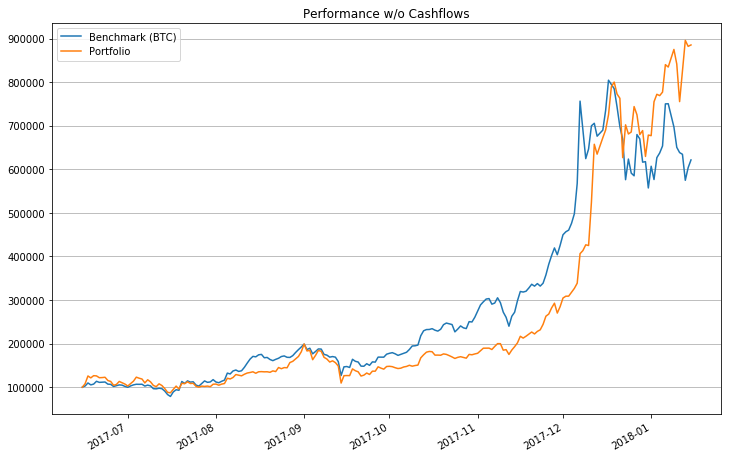

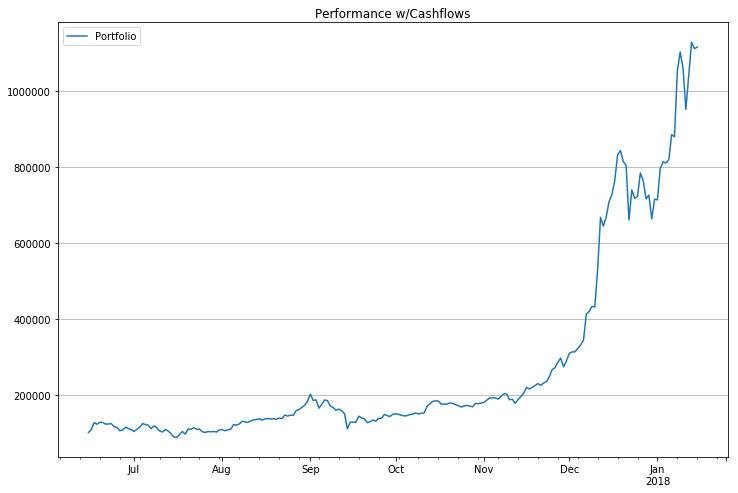

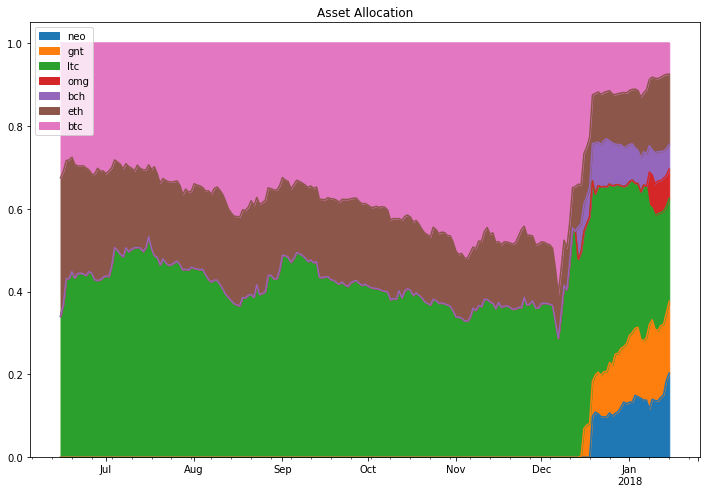

In [5]:
%matplotlib inline

print('STATISTICS')
print('---------------------------------------------------------------')
print('\t\t\tBenchmark (BTC)\t\tPortfolio')
print('Total Return\t\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_total_return, 100 * total_return))
print('Annualized Return\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_annualized_return, 100 * annualized_return))
print('Annualized Volatility\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_annualized_volatility, \
                                                   100 * annualized_volatility))
print('CAGR\t\t\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_cagr, 100 * cagr))
print('Sharpe Ratio\t\t%.2f\t\t\t%.2f' % (benchmark_sharpe_ratio, sharpe_ratio))
print('Sortino Ratio\t\t%.2f\t\t\t%.2f' % (benchmark_sortino_ratio, sortino_ratio))
print('Alpha\t\t\tN/A\t\t\t%.1f%%' % (100 * alpha))
print('Beta\t\t\tN/A\t\t\t%.1f%%' % (100 * beta))
print('---------------------------------------------------------------')

pd.options.mode.chained_assignment = None

# Simple performance excluding cashflows plot
performance.plot(figsize=(12, 8))
plt.title('Performance w/o Cashflows')
plt.grid(axis='y')
plt.show()

# Simple performance with cashflows plot
portfolio_performance.plot(figsize=(12, 8))
plt.title('Performance w/Cashflows')
plt.legend(['Portfolio'])
plt.grid(axis='y')
plt.show()

# Asset allocation stacked plot
asset_allocation = pd.DataFrame(0, index=trade_dates, columns=tickers)
for date, asset_values in asset_performance.items():
    total_value = sum(asset_values.values())
    for ticker, value in asset_values.items():
        asset_allocation[ticker].loc[date] = value / total_value
asset_allocation.plot.area(figsize=(12, 8))
plt.title('Asset Allocation')
plt.legend(loc='upper left')
plt.show()

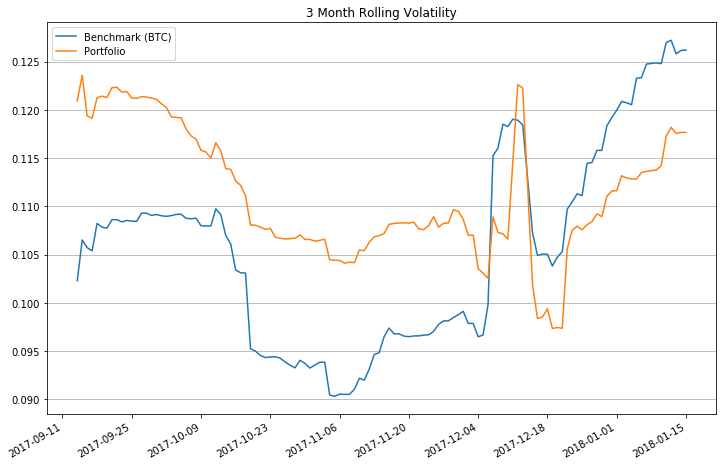

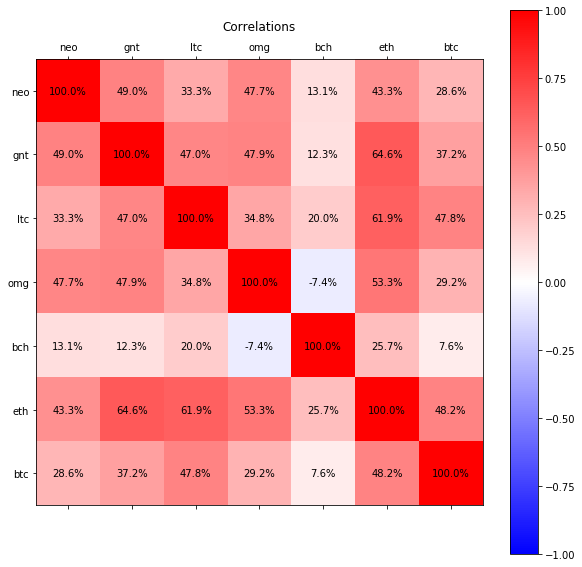

MS


In [6]:
# Rolling volatility chart
rolling_volatility = pd.DataFrame(index=portfolio_rolling_volatility.index, \
                                  columns=['Benchmark (BTC)', 'Portfolio'])
rolling_volatility['Benchmark (BTC)'] = benchmark_rolling_volatility
rolling_volatility['Portfolio'] = portfolio_rolling_volatility
rolling_volatility.plot(figsize=(12, 8))
plt.title('3 Month Rolling Volatility')
plt.grid(axis='y')
plt.show()

# Correlation matrix heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticklabels([''] + list(asset_correlations.keys()))
ax.set_yticklabels([''] + list(asset_correlations.keys()))
cax = ax.matshow(asset_correlations, cmap='bwr', vmin=-1.0, vmax=1.0)
for (i, j), z in np.ndenumerate(asset_correlations):
    ax.text(j, i, '{:.1f}%'.format(100 * z), ha='center', va='center')
plt.title('Correlations')
plt.colorbar(cax)
plt.show()
print('MS')